<a href="https://colab.research.google.com/github/msibriani/information_retrieval_eq2/blob/main/Avance4_Equipo2_parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

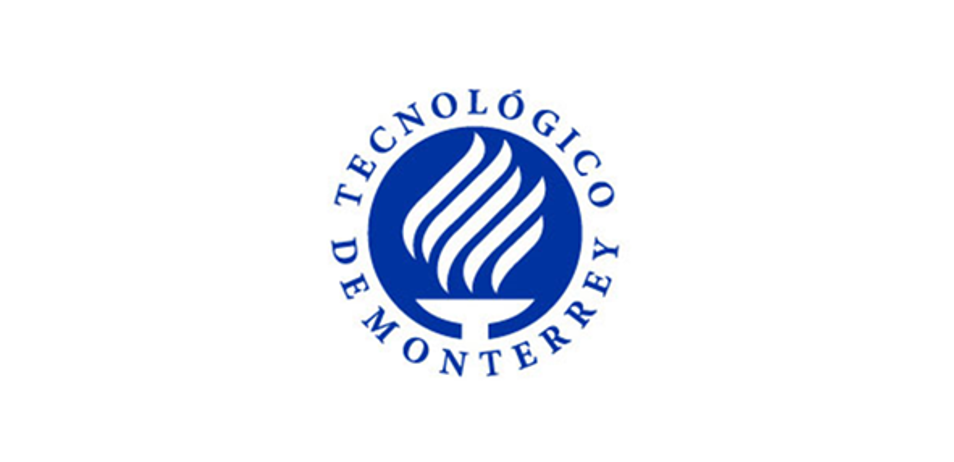

# MNA Maestría en Inteligencia Artificial Aplicada
# MNA Maestría en Inteligencia Artificial Aplicada

### Materia: TC5035.10 Proyecto Integrador
 (Gpo 10)



### Prof. Titulares:
### Dra. Grettel Barceló Alonso
### Dr. Luis Eduardo Falcón Morales



### Avance 5. Modelo final.



### EQUIPO 2
### Alumnos - Matrícula
### **Matthias Sibrian Illescas - A01794249**
### **José Ramiro Adán Charles - A00174646**
### **Genaro Ramos Higuera - A00351269**

### INTRODUCCIÓN
El jueves 30 de Mayo se llevó a cabo una sesión con el equipo funcional del Tecnológico de Monterrey, para obtener una retroalimentación sobre las respuestas generadas por el modelo a cada una de las **14 preguntas** definidas para la evaluación del mismo.
Por la complejidad de las preguntas, solo 3 de estas fueron evaluadas, y se tiene el acuerdo de incrementar la cantidad en la primer semana de Junio, sin embargo, cabe mencionar que los comentarios fueron positivos y se enfatizó en la posibilidad de incluir el nombre del documento (archivo) sobre la cual se extraen las respuestas.

Por lo que el siguiente Notebook contiene lo siguiente:
- Se hace una corrida de generación de respuestas a las 14 preguntas utilizando el modelo final seleccionado: ***gpt-3.5-turbo de OpenAI***
- Respecto al avance anterior, se añaden el nombre del documento pdf como meta-data para incluirlo a cada respuesta como fuente(s) de la misma.
- Como equipo, hacmeos una evaluación de las respuestas a 10 de las preguntas usando como referencia las respuestas esperadas (proporciandas por equipo funcional), dando como resultado **8 de 10**.
- Adicionalmente evaluamos el F1-Score utilizando la libreria de BERT-Score que usa la media armónica de precision y recall de las respuestas esperadas (por el equipo funcional) y las respuestas del modelo, dando un **promedio de 0.6429** en las 10 preguntas.
- Conclusión al final del Notebook.

###Instalamos librerias de trabajo

In [1]:
pip uninstall -y farm-haystack haystack-ai

Found existing installation: haystack-ai 2.1.2
Uninstalling haystack-ai-2.1.2:
  Successfully uninstalled haystack-ai-2.1.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip3 install torch torchvision --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu


In [3]:
!pip3 install haystack-ai
!pip3 install "sentence-transformers>=2.2.0"
!pip3 install pypdf

  Using cached lxml-5.2.2-cp312-cp312-macosx_10_9_universal2.whl.metadata (3.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.2/345.2 kB 3.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 837.8/837.8 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 10.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 9.4 MB/s eta 0:00:00


Cargamos librerias y definimos los metodos para cargar en memoria los documentos y la conversion de los PDFs

In [4]:
from PyPDF2 import PdfReader
from haystack.components.converters import PyPDFToDocument

In [5]:
class CustomPDFToDocument(PyPDFToDocument):
    def _read_pdf(self, file_path, **kwargs):
        pdf_reader = PdfReader(file_path)
        document = super()._read_pdf(file_path, **kwargs)
        document.meta["file_path"] = file_path
        document.meta["file_name"] = file_path.split("/")[-1]
        # Extrae otros metadatos que necesites (autor, título, etc.)
        return document

In [6]:
from haystack.components.writers import DocumentWriter
from haystack.components.converters import PyPDFToDocument
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack.components.routers import FileTypeRouter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()
file_type_router = FileTypeRouter(mime_types=["application/pdf"])
#Custom function para incluir meta datos como el nombre del archivo pdf.
pdf_converter = CustomPDFToDocument()


Definimos el metodo para limpiar los documentos

In [7]:
document_cleaner = DocumentCleaner()
document_splitter = DocumentSplitter(split_by="word", split_length=200, split_overlap=50)

Agregamos el embedder que utilizaremos en el Pipeline para los documentos que escribiremos en la document store.

In [8]:
#Incluimos los metadatos.
document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/distiluse-base-multilingual-cased-v2", meta_fields_to_embed=["file_name", "file_path"])
document_writer = DocumentWriter(document_store)


Ahora armamos la secuencia del Pipeline a aplicar a los documentos PDF

In [9]:
preprocessing_pipeline = Pipeline()
preprocessing_pipeline.add_component(instance=file_type_router, name="file_type_router")
preprocessing_pipeline.add_component(instance=pdf_converter, name="pypdf_converter")
preprocessing_pipeline.add_component(instance=document_cleaner, name="document_cleaner")
preprocessing_pipeline.add_component(instance=document_splitter, name="document_splitter")
preprocessing_pipeline.add_component(instance=document_embedder, name="document_embedder")
preprocessing_pipeline.add_component(instance=document_writer, name="document_writer")


Ahora conectamos el Pipeline:

In [10]:
preprocessing_pipeline.connect("file_type_router.application/pdf", "pypdf_converter.sources")
preprocessing_pipeline.connect("pypdf_converter", "document_cleaner")
preprocessing_pipeline.connect("document_cleaner", "document_splitter")
preprocessing_pipeline.connect("document_splitter", "document_embedder")
preprocessing_pipeline.connect("document_embedder", "document_writer")


🚅 Components
  - file_type_router: FileTypeRouter
  - pypdf_converter: CustomPDFToDocument
  - document_cleaner: DocumentCleaner
  - document_splitter: DocumentSplitter
  - document_embedder: SentenceTransformersDocumentEmbedder
  - document_writer: DocumentWriter
🛤️ Connections
  - file_type_router.application/pdf -> pypdf_converter.sources (List[Path])
  - pypdf_converter.documents -> document_cleaner.documents (List[Document])
  - document_cleaner.documents -> document_splitter.documents (List[Document])
  - document_splitter.documents -> document_embedder.documents (List[Document])
  - document_embedder.documents -> document_writer.documents (List[Document])

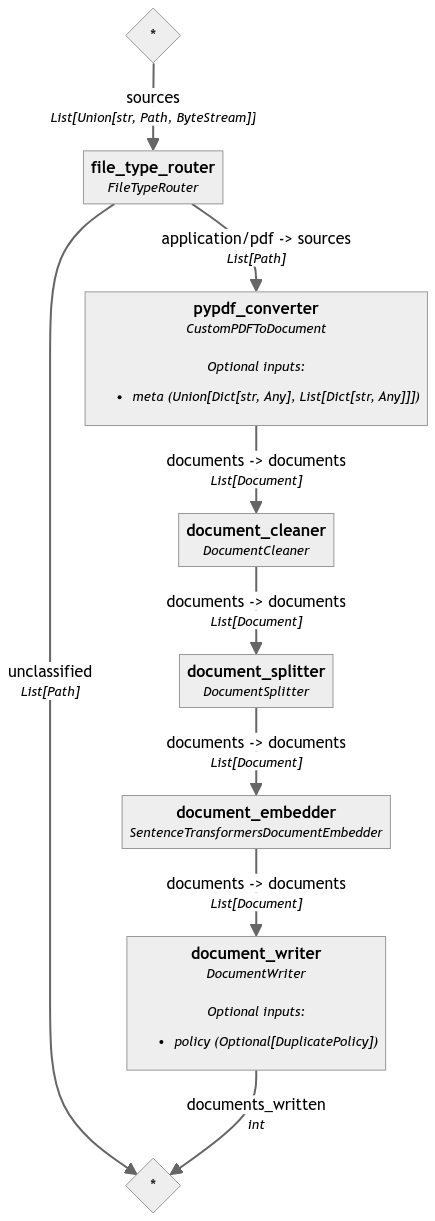

In [11]:
preprocessing_pipeline.show()

###Cargamos todos los documentos de la carpeta de PDFs /content/data/pdf
###y aplicamos el Pipeline de preprocesamiento

In [12]:
from pathlib import Path
#carpeta_pdfs = "/content/data/pdf"
#ESTABLECER EN PATHLIB LA RUTA DE LOS PDFS LOCALES
carpeta_pdfs = "/Users/joseradan/Library/CloudStorage/GoogleDrive-jradanc@gmail.com/Mi unidad/Maestria MNA/Proyecto Integrador/data/pdf"

preprocessing_pipeline.run({"file_type_router": {"sources": list(Path(carpeta_pdfs).glob("**/*"))}})

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/149 [00:00<?, ?it/s]

{'document_writer': {'documents_written': 4765}}

Ahora utilizaremos el mismo embedder para las preguntas (questions) y poder hacer la recuperacion mediante el Retriever.

In [13]:
from haystack.components.embedders import SentenceTransformersTextEmbedder

text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/distiluse-base-multilingual-cased-v2")

In [14]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

retriever = InMemoryEmbeddingRetriever(document_store)

Ahora definimos el prompt builder para las preguntas y le decimos que tome el contexto de los documentos para generar las respuestas

In [15]:
from haystack.components.builders import PromptBuilder
#Given the following information, answer the question.
template = """
Create a concise and informative answer for a given question based solely on the given documents.
You must only use information from the given documents and cite the documents you used by mentioning
their file_name or file name and document title in the answers.
For example, finish your answer with "Como se menciona en el documento: "

Context:
{% for document in documents %}
    Content: {{ document.content }}
    Metadata: {{ document.meta }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)

Ahora cargamos el API Key para el LLM que utilizaremos:

In [16]:
import os
from getpass import getpass
from haystack.components.generators import OpenAIGenerator

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")


In [17]:
generator = OpenAIGenerator(model="gpt-3.5-turbo")

In [18]:
basic_rag_pipeline = Pipeline()
# Adicionamos los componentes al pipeline
basic_rag_pipeline.add_component("text_embedder", text_embedder)
basic_rag_pipeline.add_component("retriever", retriever)
basic_rag_pipeline.add_component("prompt_builder", prompt_builder)
basic_rag_pipeline.add_component("llm", generator)

# Ahora los conectamos dentro del pipeline
basic_rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
basic_rag_pipeline.connect("retriever", "prompt_builder.documents")
basic_rag_pipeline.connect("prompt_builder", "llm")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

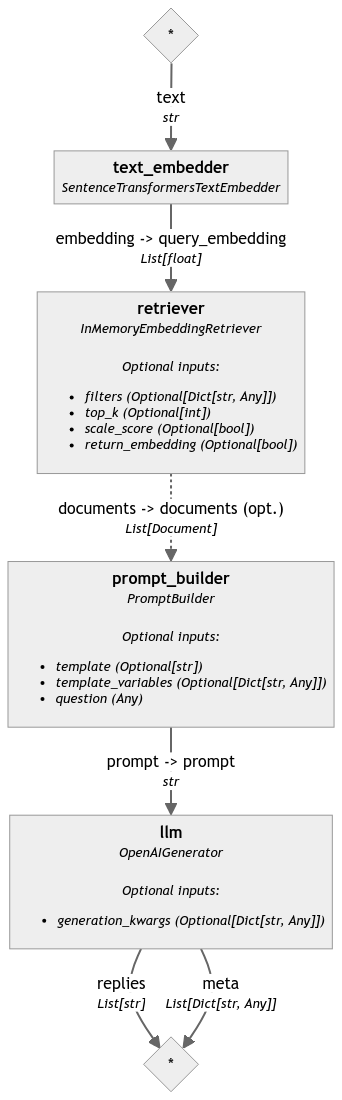

In [19]:
basic_rag_pipeline.show()

## Ahora haremos las siguientes preguntas al LLM y que se base en el contexcto de documentos

1. ¿Cuál es la definición exacta de un crédito académico en nuestra institución para los 3 niveles Preparatoria, Profesional y Posgrado?
2. ¿Cómo se determina la equivalencia de un crédito académico en términos de horas de trabajo del estudiante (lecturas, prácticas, estudio independiente, etc.)?
3. ¿Qué normativas nacionales o internacionales estamos siguiendo para la asignación de créditos académicos?
4. ¿Cuál es el proceso para evaluar y asignar créditos a un nuevo curso o programa académico?
5. ¿Cómo se aseguran los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas?
6. ¿Cómo se calcula la carga de trabajo del estudiante para determinar el número de créditos de un curso?
7. ¿Se considera la carga de trabajo fuera del aula (como tareas y proyectos) al asignar créditos?
8. ¿De qué manera se comunica a los estudiantes la información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada?
9. ¿Cómo se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional?
10. ¿Cuál es el proceso para la transferencia de créditos de otras instituciones y cómo se asegura su equivalencia?
11. ¿Cómo influyen los créditos académicos en el progreso y la planificación académica de los estudiantes?
12. ¿Con qué frecuencia se revisan y actualizan las políticas de créditos académicos?
13. ¿Qué criterios se utilizan para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso?
14. El crédito académico representa las horas de dedicación de un alumno en un curso bajo supervisión de un profesor y actividades independientes, ¿cuál es la distribución de horas en el cálculo de un crédito?
15. ¿Qué datos son los que se incluyen en el concepto de carga académica?

In [20]:
question = "1. ¿Cuál es la definición exacta de un crédito académico en nuestra institución para los 3 niveles Preparatoria, Profesional y Posgrado?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


En nuestra institución, la definición exacta de un crédito académico es la siguiente para los 3 niveles:
- En preparatoria, tres créditos académicos son equivalentes a seis unidades académicas.
- En nivel profesional, tres créditos académicos son equivalentes a ocho unidades académicas.
- En nivel de posgrado, tres créditos académicos son equivalentes a doce unidades académicas. 
Como se menciona en el documento "políticas_normas_2018_eng.pdf" y "reglamento_becas_preparatoria_profesional_2019_eng.pdf"


In [21]:
question = "2. ¿Cómo se determina la equivalencia de un crédito académico en términos de horas de trabajo del estudiante (lecturas, prácticas, estudio independiente, etc.)?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La equivalencia de un crédito académico en términos de horas de trabajo del estudiante se determina de la siguiente manera:
- Un crédito académico implica una hora de clase semanal más 180 minutos de trabajo independiente por semana durante al menos 15 semanas (políticas_normas_2015_eng.pdf).
- En programas semestrales, una hora de clase semanal corresponde a un crédito académico. En cursos de laboratorio, dos horas de laboratorio corresponden a un crédito académico (políticas_normas_2015_eng.pdf).
- Para programas de graduados semestrales, los créditos semestrales se calculan dividiendo el total de unidades del curso por cuatro (politicas_normas_2016_eng.pdf). Como se menciona en el documento: políticas_normas_2015_eng.pdf, políticas_normas_2016_eng.pdf.


In [41]:
question = "2b. ¿Cómo se determina la equivalencia de un crédito académico en términos de horas de trabajo independiente del alumno?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La equivalencia de un crédito académico en términos de horas de trabajo independiente del alumno se determina en base a las siguientes consideraciones:

- Un crédito académico implica una hora de clase semanal más 180 minutos de trabajo independiente por semana a lo largo de al menos 15 semanas (Documento: politicas_normas_2016_eng.pdf).
- En programas de posgrado semestrales, los créditos se calculan dividiendo el número total de unidades del curso entre cuatro (Documento: politicas_normas_2016_eng.pdf).
- En programas de postgrado trimestrales, los créditos se calculan dividiendo el número total de unidades entre cuatro y multiplicándolos por 0.75 debido a la diferencia en la duración de los períodos académicos (Documento: politicas_normas_2016_eng.pdf).
- Para residen-cias médicas y programas académicos en el área de la salud, una hora de clase semanal equivale a un crédito académico, dos horas de trabajo de laboratorio corresponden a un crédito académico y cinco horas de práctica c

In [22]:
question = "3. ¿Qué normativas nacionales o internacionales estamos siguiendo para la asignación de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Para la asignación de créditos académicos, estamos siguiendo las normativas establecidas en el "Reglamento para alumnos de programas internacionales en el extranjero" y en las "Políticas y Normas Académicas Generales", las cuales contienen directrices relacionadas con la aplicación, participación y proceso de transferencia de créditos para unidades educativas estudiadas en instituciones internacionales. Como se menciona en el documento "Correo_Oficial_ITESM_0085_ED_071_Anexo1" y "politicas_normas_eng": 


In [23]:
uestion = "4. ¿Cuál es el proceso para evaluar y asignar créditos a un nuevo curso o programa académico?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Para la asignación de créditos académicos, seguimos las normativas establecidas en el "Reglamento para alumnos de programas internacionales en el extranjero" y en las "Políticas y Normas Académicas Generales". Estos documentos establecen directrices relacionadas con la aplicación, participación y proceso de transferencia de créditos para unidades educativas estudiadas en instituciones extranjeras, así como para cursos tomados en el extranjero en el marco de programas internacionales. (Documento: Correo_Oficial_ITESM_0085_ED_071_Anexo1.pdf, Documento: politicas_normas_eng.pdf) Como se menciona en los documentos: "Article 170 Award of credit for the courses in the curriculum of a student who participates in an international program is based on the guidelines stipulated in the Regulations for Managing and Operating International Programs."


In [24]:
question = "5. ¿Cómo se aseguran los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Para asegurar los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas, se deben seguir ciertos lineamientos y normas académicas. Por ejemplo, los programas de doble titulación deben garantizar que los resultados de aprendizaje sean comparables a los del programa tradicional (Correo_Oficial_ITESM_0056_ED_047_Anexo1.pdf). Además, se establece que los créditos académicos se calculan de manera específica para cada nivel de estudios, dependiendo de la duración de los periodos académicos (Correo_Oficial_ITESM_0353_ED_256.pdf). Asimismo, se menciona la importancia de evaluar y dar seguimiento a los cursos impartidos por universidades extranjeras para asegurar la calidad y coherencia de los mismos (Correo_Oficial_ITESM_0056_ED_047_Anexo1.pdf).

Como se menciona en los documentos "Correo_Oficial_ITESM_0056_ED_047_Anexo1.pdf" y "Correo_Oficial_ITESM_0353_ED_256.pdf", los estándares de calidad y coherencia en la asignación de créditos s

In [25]:
question = "6. ¿Cómo se calcula la carga de trabajo del estudiante para determinar el número de créditos de un curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La carga de trabajo del estudiante se determina según el número de unidades asignadas a un curso, las cuales se calculan en función de las horas de trabajo que el curso requiere por semana. En el caso de programas de atención médica con actividades clínicas, la carga académica se mide por el tiempo total por semana que el curso requiere de los estudiantes. Cada curso se asigna un número dado de unidades, las cuales se determinan de manera que el total de unidades para los cursos en un semestre de un plan de estudios sea similar a los de un semestre de los planes de licenciatura, maestría y doctorado (Archivo: politicas_normas_2018_eng.pdf). Como se menciona en el documento: politicas_normas_2018_eng.pdf


In [26]:
question = "7. ¿Se considera la carga de trabajo fuera del aula (como tareas y proyectos) al asignar créditos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sí, se considera la carga de trabajo fuera del aula, como tareas y proyectos, al asignar créditos. Según lo mencionado en el documento "Correo_Oficial_ITESM_0484_Anexo.pdf" bajo la sección CA: Créditos académicos, se establece que las horas dedicadas al trabajo independiente del alumno también forman parte de la asignación de créditos académicos. Se menciona que a cada hora de clase se deben asignar tres horas de trabajo independiente del alumno para cumplir con los objetivos del curso. Como se menciona en el documento: "Correo_Oficial_ITESM_0484_Anexo.pdf"


In [27]:
question = "8. ¿De qué manera se comunica a los estudiantes la información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada se comunica a los estudiantes a través del reglamento de becas y préstamos para estudiantes de preparatoria y profesional. Según el documento, los cursos son asignados con un número de unidades que es menor al número total de horas de trabajo por semana que requiere el curso. Además, se establece que un crédito académico incluye un cierto número de horas dedicadas a actividades académicas. Como se menciona en el documento "reglamento_becas_preparatoria_profesional_eng.pdf".


In [28]:
question = "9. ¿Cómo se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional se garantiza a través de la traducción de la escala de calificaciones de las universidades extranjeras a su equivalente con el Sistema Tecnológico de Monterrey, como se menciona en el documento "Correo_Sistema_ITESM_467.pdf". Además, se establece que los alumnos deben ser informados sobre los criterios de calificación y carga académica del programa antes de su partida, y se acuerda que la equivalencia entre créditos académicos y unidades académicas se define de manera específica para cada nivel de estudio y tipo de programa, según lo establecido en los documentos "politicas_normas_2010_esp.pdf" y "politicas_normas_esp.pdf". Por lo tanto, la comparabilidad se asegura mediante acuerdos y especificaciones detalladas en los convenios internacionales y normas académicas del Tecnológico de Monterrey. Como se menciona en los documentos mencionados.


In [29]:
question = "10. Cuál es el proceso para la transferencia de créditos de otras instituciones y cómo se asegura su equivalencia?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

El proceso para la transferencia de créditos de otras instituciones en el Tecnológico de Monterrey implica que los acuerdos de crédito y equivalencia deben ser obtenidos por el estudiante al momento de su admisión y serán válidos para cualquier otro campus si el estudiante se transfiere después de completar al menos dos semestres en el campus inicial (políticas_normas_2013_eng.pdf, Article 23). Además, los cursos que se desean transferir deben ser similares en contenido tanto a los de la otra institución como a los cursos del Tecnológico de Monterrey, y deben haber sido aprobados con una calificación mínima de 80 sobre 100, además de cumplir con otras regulaciones establecidas (políticas_normas_2017_eng.pdf, Article 14 ; políticas_normas_2016_eng.pdf, Article 10). Como se menciona en el documento: políticas_normas_2013_eng.pdf, políticas_normas_2017_eng.pdf, políticas_normas_2016_eng.pdf.


In [30]:
question = "11. ¿Cómo influyen los créditos académicos en el progreso y la planificación académica de los estudiantes?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los créditos académicos afectan el progreso y la planificación académica de los estudiantes al determinar el número de cursos que deben aprobar para mantener su beca. Para estudiantes de pre-2019, el número de cursos suspendidos equivale al número de faltas, mientras que para estudiantes de 2019 en adelante, el número de faltas se calcula según la cantidad de créditos académicos fallados en el período. Además, los estudiantes deben obtener un promedio final igual o superior a 85/100 para mantener su beca según el programa correspondiente. Como se menciona en el documento "reglamento_becas_preparatoria_profesional_eng_2022_ junio.pdf".


In [31]:
question = "12. ¿Con qué frecuencia se revisan y actualizan las políticas de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Las políticas de créditos académicos se revisan y actualizan regularmente, como se menciona en el documento "politicas_normas_eng.pdf" en el que se detalla la modificación de diferentes artículos y la inclusión de nuevas políticas relacionadas con los créditos académicos. Como se menciona en el documento: "politicas_normas_eng.pdf" y "politicas_normas_2015_eng.pdf"


In [32]:
question = "13. ¿Qué criterios se utilizan para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso, se utilizan los criterios de definir la carga académica en créditos académicos y modificar la definición de carga académica en créditos académicos en el Artículo 32, así como ajustar las horas de dedicación por crédito en los programas de posgrado de acuerdo con las horas de sesiones con el profesor y trabajo independiente del estudiante en los programas trimestrales y intensivos mencionados en los cambios de los Programas de Posgrado en el documento "Correo_Oficial_ITESM_0751 (1).pdf". Como se menciona en el documento: "Correo_Oficial_ITESM_0751 (1).pdf"


In [33]:
question = "14. El crédito académico representa las horas de dedicación de un alumno en un curso bajo supervisión de un profesor y actividades independientes, ¿cuál es la distribución de horas en el cálculo de un crédito?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Según los documentos proporcionados, el cálculo de un crédito académico implica una clase de 50 minutos más 180 minutos de trabajo independiente por semana durante al menos 15 semanas, lo que equivale a 50 minutos de clase por semana correspondientes a un crédito académico. Además, se menciona que para programas graduados semestrales, las horas-crédito por semestre se calculan dividiendo el total de unidades del curso entre cuatro, y para programas trimestrales se multiplica el total de unidades del curso por 0.75 para obtener las horas-crédito equivalentes al semestre. Como se menciona en el documento de "politicas_normas_2016_eng.pdf" y en "Correo_Sistema_ITESM_1453_ED_495_Anexo1.pdf":


In [34]:
question = "15. ¿Qué datos son los que se incluyen en el concepto de carga académica?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Según el documento "politicas_normas_eng.pdf", los datos incluidos en el concepto de carga académica son las horas de clase por semana, las horas de laboratorio por semana, las horas de aprendizaje supervisado por semana y los créditos académicos asignados a cada unidad educativa. Esto se menciona en el siguiente fragmento: "La carga académica debe especificarse en cada curso con la siguiente nomenclatura: C: horas de clase por semana, L: horas de laboratorio por semana, A: horas de aprendizaje supervisado por semana, CA: créditos académicos. Estas unidades representan el tiempo de trabajo que un estudiante dedica a la unidad educativa para cumplir con sus objetivos". Como se menciona en el documento "politicas_normas_eng.pdf"


In [35]:
!pip3 install bert_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Usamos bert_score para evaluar la similaridad entre referencia y resultado de cada una de las 10 respuestas de las cuales se tiene la informacion por parte del equipo funcional.

Las preguntas que se evalúan son:

1. ¿Cuál es la definición exacta de un crédito académico en nuestra institución para los 3 niveles Preparatoria, Profesional y Posgrado?
3. ¿Qué normativas nacionales o internacionales estamos siguiendo para la asignación de créditos académicos?
7. ¿Se considera la carga de trabajo fuera del aula (como tareas y proyectos) al asignar créditos?
8. ¿De qué manera se comunica a los estudiantes la información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada?
9. ¿Cómo se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional?
10. ¿Cuál es el proceso para la transferencia de créditos de otras instituciones y cómo se asegura su equivalencia?
11. ¿Cómo influyen los créditos académicos en el progreso y la planificación académica de los estudiantes?
12. ¿Con qué frecuencia se revisan y actualizan las políticas de créditos académicos?
13. ¿Qué criterios se utilizan para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso?
14. El crédito académico representa las horas de dedicación de un alumno en un curso bajo supervisión de un profesor y actividades independientes, ¿cuál es la distribución de horas en el cálculo de un crédito?

In [36]:
from bert_score import score

In [37]:
references = ['Las unidades de formación de una carrera profesional deben diseñarse de modo que se cumpla la definición de crédito académico, es decir que por cada 15 horas-clase, el estudiante dedique, al menos, 25 horas de trabajo independiente en actividades de la unidad de formación. Además, cada crédito académico debe incluir 8 horas dedicados a las actividades académicas de las unidades de formación de Semana Tec. el tiempo dedicado a estas actividades es adicional al definido en el párrafo anterior.'
              ,'Definición de crédito Académico para SACSCOC: “Not less than one hour of classroom or direct faculty instruction and a minimum of two hours out of class student work each week for approximately fifteen weeks for one semester'
              ,'Si'
              ,'A través del reglamento académico de cada nivel y de su plan curricular'
              ,'Se garantiza comparando el tiempo dedicado por el alumno para cada asignatura, dividido en contacto directo con docente y trabajo independiente.'
              ,'Siguiendo el proceso establecido en la institución para revalidación y equivalencias donde se tiene que cumplir la regla que la materia a acreditar deba ser similar en un 80 por ciento en contenidos y con una evaluación de 80/100 o su equivalente.'
              ,'Un crédito académico indica el avance curricular de un plan de estudios, también existe por normativa un máximo y mínimo de créditos por inscribir así como otras reglas en el proceso de inscripción que se deben cumplir.'
              ,'Cada 5 años se revisan y actualizan los planes de estudio que incluyen la revisión de créditos académicos'
              ,'El criterio principal es el número de contenidos y el tiempo de trabajo que requiere el alumno para cubrir dichos contenidos'
              ,'Por cada 15 horas-clase, el estudiante dedique, al menos, 25 horas de trabajo independiente en actividades de la unidad de formación.']
candidates = ['Según lo establecido en el documento "reglamento_becas_preparatoria_profesional_esp.pdf" en la página 9, un crédito académico de preparatoria equivale a seis unidades académicas, un crédito académico de profesional equivale a ocho unidades académicas, y un crédito académico de posgrado equivale a doce unidades académicas. También se menciona en el documento "politicas_normas_2018_eng.pdf" en la página 66 que un crédito académico en programas de maestría debe tener 54 horas de trabajo durante el periodo académico. Como se menciona en los documentos: "reglamento_becas_preparatoria_profesional_esp.pdf" y "politicas_normas_2018_eng.pdf"'
              ,'Estamos siguiendo las normativas de revalidación, equivalencia y asignación de créditos según los convenios de colaboración con universidades extranjeras, especificadas en los artículos 9, 12, y 13 de las políticas y normas académicas (source: politicas_normas_2018_eng.pdf, politicas_normas_eng.pdf). Como se menciona en los documentos:'
              ,'Sí, al asignar créditos se considera que a cada hora de clase corresponda tres horas de trabajo independiente del alumno, lo que implica que se incluye la carga de trabajo fuera del aula. Como se menciona en el documento "POLÍTICAS Y NORMAS ACADÉMICAS GENERALES" en el artículo 106 del archivo "politicas_normas_2015_esp.pdf".'
              ,'La información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada se comunica a los estudiantes a través del diseño de los planes de estudio. Cada curso se asigna un determinado número de unidades, el cual es menor que el número de horas totales de trabajo a la semana que el curso demanda a los alumnos. Este número de unidades se determina de manera que el total sea similar al de un semestre de los planes de estudio de profesional, maestría y doctorado (Regulations on Scholarships and Student Loans for High School and Undergraduate Students, 2022, p. 2). Además, se establece que cada clase hora semanal de un curso corresponde a una hora-crédito por semestre, y para cursos de investigación y tesis en programas de posgrado, las horas-crédito por semestre se calculan dividiendo el total de unidades entre cuatro (Regulations on Scholarships and Student Loans for High School and Undergraduate Students, 2017, p. 10). Como se menciona en el documento: "Con objeto de mostrar la equivalencia de unidades por semestre utilizadas en el Tecnológico de Monterrey con el concepto de horas-crédito por semestre, utilizadas en otras instituciones extranjeras" (Regulations on Scholarships and Student Loans for High School and Undergraduate Students, 2022, p. 2).'
              ,'La comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional se garantiza a través de la traducción de las escalas de calificaciones de universidades extranjeras a su equivalente en el Sistema Tecnológico de Monterrey, como se menciona en el documento "Correo_Sistema_ITESM_467.pdf". Además, se establece que los planes de estudio deben tener una ventaja diferencial clara con respecto a otros programas académicos similares, acordes al desarrollo del conocimiento en el campo correspondiente, según lo establecido en los documentos políticas_normas_2010_esp.pdf, politicas_normas_esp.pdf, y politicas_normas_2007_esp.pdf. También se menciona que la acreditación de unidades de formación por cursos de idiomas en el extranjero se permite bajo ciertas condiciones, como la inclusión de la calificación final del curso en el transcript emitido por la institución extranjera, según el documento Correo_Oficial_ITESM_0056_ED_047_Anexo1.pdf. Como se menciona en los documentos: Correo_Sistema_ITESM_467.pdf, políticas_normas_2010_esp.pdf, politicas_normas_esp.pdf, politicas_normas_2007_esp.pdf y Correo_Oficial_ITESM_0056_ED_047_Anexo1.pdf.'
              ,'El proceso para la transferencia de créditos de otras instituciones en el Tecnológico de Monterrey involucra que los acuerdos de transferencia de créditos y equivalencias deben ser solicitados por el estudiante y estar respaldados por el Ministerio de Educación de México, basados en una propuesta presentada por el Tecnológico de Monterrey para cada caso individual (políticas_normas_2016_eng.pdf). Para que estos acuerdos sean aceptados, los cursos completados en instituciones reconocidas por el Ministerio de Educación de México deben tener al menos una calificación de 80 en una escala de 0 a 100 (reglamento_becas_preparatoria_profesional_2022_esp.pdf). Además, los cursos a ser transferidos deben ser similares a los ofrecidos por el Tecnológico de Monterrey en términos de contenido y duración (políticas_normas_2016_eng.pdf). Como se menciona en el documento: políticas_normas_2016_eng.pdf "Transfer credit and equivalency agreements of students who register at Tecno lógico de Monterrey with partial studies from an academic period completed at another educational institution are issued by the Mexican Ministry of Education, based on a proposal put forward for each individual case by Tecnológico de Monterrey. The academic senates must stipulate regulations for these proposals, in accordance with the provisions of the other articles in this section."'
              ,'Los créditos académicos tienen un impacto directo en el progreso y la planificación académica de los estudiantes, especialmente en lo que respecta a la obtención y mantenimiento de becas y ayudas financieras. Según el Reglamento de Becas Preparatoria y Profesional del Tecnológico de Monterrey (2015), los estudiantes que no cumplan con los créditos académicos requeridos pueden enfrentar sanciones como la reducción o cancelación de su beca. Por ejemplo, en caso de no aprobar un curso, el número de créditos fallidos se traduce en un número correspondiente de faltas, lo cual puede afectar su estatus de becario. Además, al cambiar de carrera, se debe tener en cuenta el aumento en el número de cursos y créditos académicos, lo cual puede requerir una autorización específica para mantener la ayuda financiera. Como se menciona en el documento: reglamento_becas_preparatoria_profesional_2015_eng.pdf, reglamento_becas_preparatoria_profesional_2022_eng.pdf.'
              ,'Las políticas de créditos académicos se revisan y actualizan regularmente, como se menciona en el documento "politicas_normas_eng.pdf", en el que se detalla que se han realizado modificaciones en varios artículos relacionados con la transferencia de créditos y con la definición de carga académica. Además, se incluyen nuevas políticas y normas que buscan fortalecer el ambiente educativo. Como se menciona en el documento "politicas_normas_eng.pdf": "The policies and procedures contained herein apply to the high school, undergraduate and graduate educational units offered at the institution in all formats (online or face-to-face programs) and at all the campuses."'
              ,'Los criterios utilizados para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso incluyen la definición de carga académica en créditos académicos y la modificación de la estructura de los programas de posgrado para alinearlos con las estrategias de investigación institucionales (Según el documento politicas_normas_eng.pdf, page 3 y politicas_normas_esp.pdf, page 1). Como se menciona en el documento: '
              ,'El crédito académico se calcula en base a una hora clase semanal, que equivale a un crédito académico. Además, dos horas de laboratorio en un curso semestral corresponden a un crédito académico (políticas_normas_2016_eng.pdf). Como se menciona en el documento: "academic credit implies one 50-minute class-hour plus 180 minutes of independent work per week throughout at least 15 weeks."']
 
P, R, F1 = score(candidates, references, lang="es", verbose=True)
print(f"BERTScore F1: {F1.mean().item():.4f}")
 
 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 3.29 seconds, 3.04 sentences/sec
BERTScore F1: 0.6329


In [38]:
F1

tensor([0.6701, 0.5979, 0.5334, 0.6073, 0.6015, 0.6412, 0.6575, 0.6742, 0.6662,
        0.6802])

In [39]:
references = ['Las unidades de formación de una carrera profesional deben diseñarse de modo que se cumpla la definición de crédito académico, es decir que por cada 15 horas-clase, el estudiante dedique, al menos, 25 horas de trabajo independiente en actividades de la unidad de formación. Además, cada crédito académico debe incluir 8 horas dedicados a las actividades académicas de las unidades de formación de Semana Tec. el tiempo dedicado a estas actividades es adicional al definido en el párrafo anterior.'
              ,'Definición de crédito Académico para SACSCOC: “Not less than one hour of classroom or direct faculty instruction and a minimum of two hours out of class student work each week for approximately fifteen weeks for one semester'
              ,'Si'
              ,'A través del reglamento académico de cada nivel y de su plan curricular'
              ,'Se garantiza comparando el tiempo dedicado por el alumno para cada asignatura, dividido en contacto directo con docente y trabajo independiente.'
              ,'Siguiendo el proceso establecido en la institución para revalidación y equivalencias donde se tiene que cumplir la regla que la materia a acreditar deba ser similar en un 80 por ciento en contenidos y con una evaluación de 80/100 o su equivalente.'
              ,'Un crédito académico indica el avance curricular de un plan de estudios, también existe por normativa un máximo y mínimo de créditos por inscribir así como otras reglas en el proceso de inscripción que se deben cumplir.'
              ,'Cada 5 años se revisan y actualizan los planes de estudio que incluyen la revisión de créditos académicos'
              ,'El criterio principal es el número de contenidos y el tiempo de trabajo que requiere el alumno para cubrir dichos contenidos'
              ,'Por cada 15 horas-clase, el estudiante dedique, al menos, 25 horas de trabajo independiente en actividades de la unidad de formación.']
candidates = ['Según los documentos proporcionados, la definición exacta de un crédito académico en Tecnológico de Monterrey es la siguiente:- Tres créditos académicos de preparatoria son equivalentes a seis unidades académicas.- Tres créditos académicos de profesional son equivalentes a ocho unidades académicas.- Tres créditos académicos de posgrado son equivalentes a doce unidades académicas.'
              ,'Según se menciona en el documento politicas_normas_2017_eng.pdf, se siguen las normativas nacionales e internacionales para la asignación de créditos académicos en el Tecnológico de Monterrey. En el artículo 169 se establece que los reglamentos de estudiantes de programas internacionales deben proporcionar pautas relacionadas con el proceso de solicitud, participación y transferencia de créditos para cursos estudiados en instituciones en el extranjero. Además, en el artículo 170 se menciona que la asignación de créditos para los cursos del plan de estudios de un estudiante que participe en un programa internacional se basa en las pautas estipuladas en los Reglamentos para la Gestión y Operación de Programas Internacionales. Como se menciona en el documento: politicas_normas_2017_eng.pdf.'
              ,'Sí, se considera la carga de trabajo fuera del aula al asignar créditos. Según los documentos, los créditos académicos representan el tiempo de trabajo que el alumno dedica a la unidad de formación para cumplir con los objetivos del mismo, incluyendo horas de clase y trabajo independiente del alumno. Además, se menciona que los cursos deben diseñarse de modo que a cada hora de clase correspondan tres horas de trabajo independiente del alumno'
              ,'La información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada se comunica a los estudiantes a través del sistema oficial establecido para este propósito por el Comité de Becas y Ayuda Financiera del Campus, de acuerdo con lo establecido por la Oficina del Vice Rector de Innovación Educativa y Normas Académicas, como se menciona en el documento REGULATIONS ON SCHOLARSHIPS AND STUDENT LOANS FOR HIGH SCHOOL AND UNDERGRADUATE STUDENTS.'
              ,'La comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional se garantiza a través de la traducción de las escalas de calificaciones de universidades extranjeras a su equivalente en el Sistema Tecnológico de Monterrey, como se menciona en el documento "Correo_Sistema_ITESM_467.pdf". Además, se establece que los planes de estudio deben tener una ventaja diferencial clara con respecto a otros programas académicos similares, acordes al desarrollo del conocimiento en el campo correspondiente, según lo establecido en los documentos políticas_normas_2010_esp.pdf, politicas_normas_esp.pdf, y politicas_normas_2007_esp.pdf. También se menciona que la acreditación de unidades de formación por cursos de idiomas en el extranjero se permite bajo ciertas condiciones, como la inclusión de la calificación final del curso en el transcript emitido por la institución extranjera, según el documento Correo_Oficial_ITESM_0056_ED_047_Anexo1.pdf. Como se menciona en los documentos: Correo_Sistema_ITESM_467.pdf, políticas_normas_2010_esp.pdf, politicas_normas_esp.pdf, politicas_normas_2007_esp.pdf y Correo_Oficial_ITESM_0056_ED_047_Anexo1.pdf.'
              ,'El proceso para la transferencia de créditos de otras instituciones en el Tecnológico de Monterrey involucra que los acuerdos de transferencia de créditos y equivalencias deben ser solicitados por el estudiante y estar respaldados por el Ministerio de Educación de México, basados en una propuesta presentada por el Tecnológico de Monterrey para cada caso individual (políticas_normas_2016_eng.pdf). Para que estos acuerdos sean aceptados, los cursos completados en instituciones reconocidas por el Ministerio de Educación de México deben tener al menos una calificación de 80 en una escala de 0 a 100 (reglamento_becas_preparatoria_profesional_2022_esp.pdf). Además, los cursos a ser transferidos deben ser similares a los ofrecidos por el Tecnológico de Monterrey en términos de contenido y duración (políticas_normas_2016_eng.pdf). Como se menciona en el documento: políticas_normas_2016_eng.pdf "Transfer credit and equivalency agreements of students who register at Tecno lógico de Monterrey with partial studies from an academic period completed at another educational institution are issued by the Mexican Ministry of Education, based on a proposal put forward for each individual case by Tecnológico de Monterrey. The academic senates must stipulate regulations for these proposals, in accordance with the provisions of the other articles in this section."'
              ,'Los créditos académicos tienen un impacto directo en el progreso y la planificación académica de los estudiantes, especialmente en lo que respecta a la obtención y mantenimiento de becas y ayudas financieras. Según el Reglamento de Becas Preparatoria y Profesional del Tecnológico de Monterrey (2015), los estudiantes que no cumplan con los créditos académicos requeridos pueden enfrentar sanciones como la reducción o cancelación de su beca. Por ejemplo, en caso de no aprobar un curso, el número de créditos fallidos se traduce en un número correspondiente de faltas, lo cual puede afectar su estatus de becario. Además, al cambiar de carrera, se debe tener en cuenta el aumento en el número de cursos y créditos académicos, lo cual puede requerir una autorización específica para mantener la ayuda financiera. Como se menciona en el documento: reglamento_becas_preparatoria_profesional_2015_eng.pdf, reglamento_becas_preparatoria_profesional_2022_eng.pdf.'
              ,'Las políticas de créditos académicos se revisan y actualizan regularmente, como se menciona en el documento "politicas_normas_eng.pdf", en el que se detalla que se han realizado modificaciones en varios artículos relacionados con la transferencia de créditos y con la definición de carga académica. Además, se incluyen nuevas políticas y normas que buscan fortalecer el ambiente educativo. Como se menciona en el documento "politicas_normas_eng.pdf": "The policies and procedures contained herein apply to the high school, undergraduate and graduate educational units offered at the institution in all formats (online or face-to-face programs) and at all the campuses."'
              ,'Los criterios utilizados para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso incluyen la definición de carga académica en créditos académicos y la modificación de la estructura de los programas de posgrado para alinearlos con las estrategias de investigación institucionales (Según el documento politicas_normas_eng.pdf, page 3 y politicas_normas_esp.pdf, page 1). Como se menciona en el documento: '
              ,'El crédito académico se calcula en base a una hora clase semanal, que equivale a un crédito académico. Además, dos horas de laboratorio en un curso semestral corresponden a un crédito académico (políticas_normas_2016_eng.pdf). Como se menciona en el documento: "academic credit implies one 50-minute class-hour plus 180 minutes of independent work per week throughout at least 15 weeks."']
 
P, R, F1 = score(candidates, references, lang="es", verbose=True)
print(f"BERTScore F1: {F1.mean().item():.4f}")

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 3.61 seconds, 2.77 sentences/sec
BERTScore F1: 0.6429


In [40]:
F1

tensor([0.6954, 0.5998, 0.5633, 0.6500, 0.6015, 0.6412, 0.6575, 0.6742, 0.6662,
        0.6802])

### CONCLUSIÓN

Se observa que las respuestas son muy amplias y en primer instancia, coherentes aún que la obtención de una respuesta correcta es muy complejo, pues puede estar dividida, replicada o contenida en múltiples documentos.

Por lo mismo, se nota la problemática que representa para el equipo funcional en ponerse de acuerdo sobre las precisión y validez de las respuestas.

Los siguientes pasos son:
- Sesiones con el equipo funcional para mostrarles las respuestas actualizadas que ya contiene el nombre del archivo y para seguir afinado el modelo.
- Sesiones con el departamento de tecnología para la viabilidad de su conexión con los servicios de Azure.